In [43]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib.dates import date2num
import seaborn
import numpy as np
import pickle
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
from plotly.subplots import make_subplots

In [44]:
df_1 = pd.read_csv("clean_data for input.csv")
df_1['Date'] = pd.to_datetime(df_1['Date'], format='%Y-%m-%d') #convert date column (strings) to datetime format

In [45]:
df_2 = pd.read_excel('Daily metric.xlsx', sheet_name = 'OAT_regr')
print(df_2.columns)
df_2['day'] = pd.to_datetime(df_2['day'], format='%m-%d')
df_2['day_revised'] = df_2['day'].apply(lambda x: x.date())

Index(['day', 'Max OAT (°F)', 'Avg OAT (°F)', '1A CHW Demand (W)',
       '1B CHW Demand (W)', 'Load Shed (W)', 'Load Decrease intensity(W/ft2)',
       '1A CHW Demand (W).1', '1B CHW Demand (W).1', 'Load Increase (W)',
       'Load Increase Intensity (W/ft2)', 'Net kWh in 24 hours', 'Comment',
       'Plot', 'Test Group'],
      dtype='object')


In [47]:
print(type(df_2['day'].iloc[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [48]:
col_list = df_1.iloc[0, 1:9]

In [49]:
print(df_1.shape)
print(df_1['1B-OAT-1'].max())

(5376, 10)
32.750306941666665


#### Adjustment factor

In [51]:
df_1['1A-Th-Chilled Water'] = df_1['1A-Th-Chilled Water']*(-1)
df_1['1B-Th-Chilled Water'] = df_1['1B-Th-Chilled Water']*(-1)

In [52]:
#print(df_1['Time'])

In [53]:
df_1['1A-Th-Chilled Water_adjusted'] = df_1['1A-Th-Chilled Water'] - 250
df_1 = df_1.assign(correction_factor = 'correction_factor') 
df_1['Time'] = pd.to_datetime(df_1['Time'], format='%H:%M')
df_1['Time'] = df_1['Time'].apply(lambda x: x.time())
for day in (df_1['Date'].unique()):
    mask_time = ((df_1['Time'] >= datetime.time(0,0,0)) & (df_1['Time'] < datetime.time(7,0,0)))
    mask_day = (df_1['Date'] == day)
    
    correction_factor_el = (df_1['1A-Th-Chilled Water'][mask_day][mask_time] - df_1['1B-Th-Chilled Water'][mask_day][mask_time]).mean()
    #df_1['correction_factor'] = correction_factor_el
    df_1.loc[df_1['Date'] == day, 'correction_factor'] = correction_factor_el

In [54]:
#print(df_1['correction_factor'].head(120))
#print(correction_factor_el)
df_1['1A-Th-Chilled Water_new_adjusted'] = df_1['1A-Th-Chilled Water'] - df_1['correction_factor']

df_1_backup = df_1.copy()
df_1['CHW_A_th_adjusted_intensity'] = df_1['1A-Th-Chilled Water_new_adjusted'].apply(lambda x: x/600) 

In [55]:
print(df_1_backup)

       1A-El-AHU  1A-Th-Chilled Water   1B-El-AHU  1B-OAT-1  \
0            NaN                  NaN         NaN       NaN   
1            NaN                  NaN         NaN       NaN   
2            NaN                  NaN         NaN       NaN   
3            NaN                  NaN         NaN       NaN   
4            NaN                  NaN         NaN       NaN   
...          ...                  ...         ...       ...   
5371  262.021794          1771.111257  262.160542  7.551167   
5372  262.111741          1695.904828  262.384397  7.556803   
5373  262.280445          1656.941715  262.581866  7.736662   
5374  262.229555          1620.452472  262.542203  7.799491   
5375  262.011864          1586.830364  262.362772  7.757881   

      1B-Th-Chilled Water       DHI       DNI       GHI       Date      Time  \
0                     NaN  0.649386  0.697050  0.791255 2020-10-04  00:00:00   
1                     NaN -0.137935  0.332051  0.587001 2020-10-04  00:15:00   
2  

#### COP calculation

In [57]:
#print(type(df_1['1B-OAT-1']))
df_1 = df_1.assign(OAT_F = 'OAT_F') 
df_1 = df_1.assign(COP='COP') 

df_1['OAT_F'] = df_1['1B-OAT-1'].apply(lambda x: (1.8*x + 32)) 
df_1['COP'] = df_1['OAT_F'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))

df_1['COP'] = df_1['COP'].fillna(3)

In [58]:
print(df_1['COP'].tail(574))

4802    3.385482
4803    3.381655
4804    3.380021
4805    3.385861
4806    3.380996
          ...   
5371    3.297807
5372    3.298066
5373    3.306245
5374    3.309064
5375    3.307199
Name: COP, Length: 574, dtype: float64


In [59]:
print(len(df_1['COP']))

5376


#### Convert thermal CHW to Electrical CHW load

In [60]:
df_1 = df_1.assign(CHW_A_El = 'CHW_A_El') 
df_1 = df_1.assign(CHW_B_El = 'CHW_B_El') 

In [61]:
df_1['CHW_A_El'] = df_1['1A-Th-Chilled Water_new_adjusted']/df_1['COP']
df_1['CHW_B_El'] = df_1['1B-Th-Chilled Water']/df_1['COP']

#### Load increase and shed calculations

In [63]:
df_1['CHW_th_diff'] = df_1['1A-Th-Chilled Water_new_adjusted'] - df_1['1B-Th-Chilled Water']
df_1['CHW_El_diff'] = df_1['CHW_A_El'] - df_1['CHW_B_El']
df_1['AHU_diff'] = df_1['1A-El-AHU'] - df_1['1B-El-AHU']

#### Masks for precool and shed duration

In [65]:
precool_dur = ((df_1['Time'] >= datetime.time(10,0,0)) & (df_1['Time'] < datetime.time(14,0,0)))
shed_dur = ((df_1['Time'] >= datetime.time(14,0,0)) & (df_1['Time'] < datetime.time(18,0,0)))

In [66]:
#df_1['Load_El'] = (df_1['CHW_El_diff'] + df_1['AHU_diff'])
df_1['Load_El'] = (df_1['CHW_El_diff'])
#df_1['Load shed'] = (df_1['CHW_diff'][shed_dur] + df_1['AHU_diff'][shed_dur])

In [67]:
print(precool_dur)

0       False
1       False
2       False
3       False
4       False
        ...  
5371    False
5372    False
5373    False
5374    False
5375    False
Name: Time, Length: 5376, dtype: bool


In [93]:
df_4['OAT'] = df_1['OAT_F'][mask_day][shed_dur]

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
5371    45.592101
5372    45.602246
5373    45.925992
5374    46.039083
5375    45.964186
Name: OAT_F, Length: 5376, dtype: float64

#### Metrics for energy intensity

In [68]:
df_1['1A-El-AHU_intensity'] = df_1['1A-El-AHU'].apply(lambda x: x/600)
df_1['1B-El-AHU_intensity'] = df_1['1B-El-AHU'].apply(lambda x: x/600)
df_1['CHW_A_El_intensity'] = df_1['CHW_A_El'].apply(lambda x: x/600)
df_1['CHW_B_El_intensity'] = df_1['CHW_B_El'].apply(lambda x: x/600)
df_1['CHW_A_th_intensity'] = df_1['1A-Th-Chilled Water_new_adjusted'].apply(lambda x: x/600) 
df_1['CHW_B_th_intensity'] = df_1['1B-Th-Chilled Water'].apply(lambda x: x/600)
df_1['CHW_th_diff_intensity'] = df_1['CHW_th_diff'].apply(lambda x: x/600)
df_1['CHW_El_diff_intensity'] = df_1['CHW_El_diff'].apply(lambda x: x/600)
df_1['AHU_El_diff_intensity'] = df_1['1A-El-AHU_intensity'] - df_1['1B-El-AHU_intensity']
df_1['Load_El_intensity'] = df_1['Load_El'].apply(lambda x: x/600)

In [69]:
df_1.to_csv('clean_output_0225_adjusted.csv',index=False)

#### Create a new dataframe which iterartes over each date and adds respective columns 

In [70]:
df_1['upper'] = 10
df_1['lower'] = -10
#print(df_1[precool_dur])
#print(df_1[shed_dur])

In [71]:
#print(dates, dates_str)
#print(dates_1, dates_str_1)

In [72]:
#test_group = {df_2['day']:df_2['Test Group']}
#pd.Series([df_2['Test Group'].values, df_2['day_revised'].values]).to_dict()
#dict(zip(df_2['day'],df_2['Test Group']))

In [73]:
dates_1 = {0: datetime.date(2020, 10, 9),
         1: datetime.date(2020, 10, 26),
         2: datetime.date(2020, 11, 19), 
         3: datetime.date(2020, 11, 1),
         4: datetime.date(2020, 11, 3),
         5: datetime.date(2020, 11, 4),
         6: datetime.date(2020, 11, 5), 
         7: datetime.date(2020, 11, 12),
         8: datetime.date(2020, 11, 26), 
         9: datetime.date(2020, 10, 29)}

dates = [datetime.date(2020, 10, 9),
         datetime.date(2020, 10, 26),
         datetime.date(2020, 11, 19), 
         datetime.date(2020, 11, 1),
         datetime.date(2020, 11, 3),
         datetime.date(2020, 11, 4),
         datetime.date(2020, 11, 5), 
         datetime.date(2020, 11, 12),
         datetime.date(2020, 11, 26), 
         datetime.date(2020, 10, 29)]

dates_1 =  df_2['day_revised'].tolist()

dates_str = [x.strftime('%m-%d') for x in dates]
dates_str_1 = [x.strftime('%m-%d') for x in dates_1]
print(dates_str_1)
#print(test_group)
print(df_1['Date'].iloc[0].date())

['11-27', '10-25', '10-28', '11-16', '11-23', '10-20', '10-22', '10-20', '10-22', '11-09', '10-29', '10-11', '10-14', '10-18', '11-25', '11-15', '10-31', '11-02', '11-01', '11-03', '11-04', '11-05', '10-12', '10-13', '10-15', '10-16', '10-17', '10-19', '11-12', '11-26', '10-21', '11-24', '11-28']
2020-10-04


### Matplotlib - Plots for select days

In [107]:
select_dates = [datetime.date(2020, 10, 21), 
                datetime.date(2020, 10, 12),
               datetime.date(2020, 10, 19),
               datetime.date(2020, 11, 12),
               datetime.date(2020, 11, 26),
               datetime.date(2020, 10, 11),
               datetime.date(2020, 10, 14),
               datetime.date(2020, 10, 18),
               datetime.date(2020, 11, 25),
               datetime.date(2020, 11, 15)]
#select_dates =  df_2['day_revised'].tolist()

#print(df_1['Date'].iloc[0].date())
'''datetime.date(2020, 11, 27), 
                datetime.date(2020, 10, 15),
                datetime.date(2020, 10, 16), 
                datetime.date(2020, 10, 14),
                datetime.date(2020, 10, 12),
                datetime.date(2020, 10, 13),
                datetime.date(2020, 10, 17),
                datetime.date(2020, 10, 19),
                datetime.date(2020, 11, 12),
                datetime.date(2020, 11, 26),
                datetime.date(2020, 10, 21)]'''
                
select_dates_str = [x.strftime('%m-%d') for x in select_dates]
#print(select_dates_str)

In [108]:
for i in range(len(select_dates)):
    
    mask_1 = [x.date() == select_dates[i] for x in df_1['Date']]
    df_plot = df_1[mask_1]
    shed_load = df_plot['CHW_El_diff_intensity'][shed_dur]
    shed_time = df_plot['Time'][shed_dur]
    #print(shed_load, shed_time)


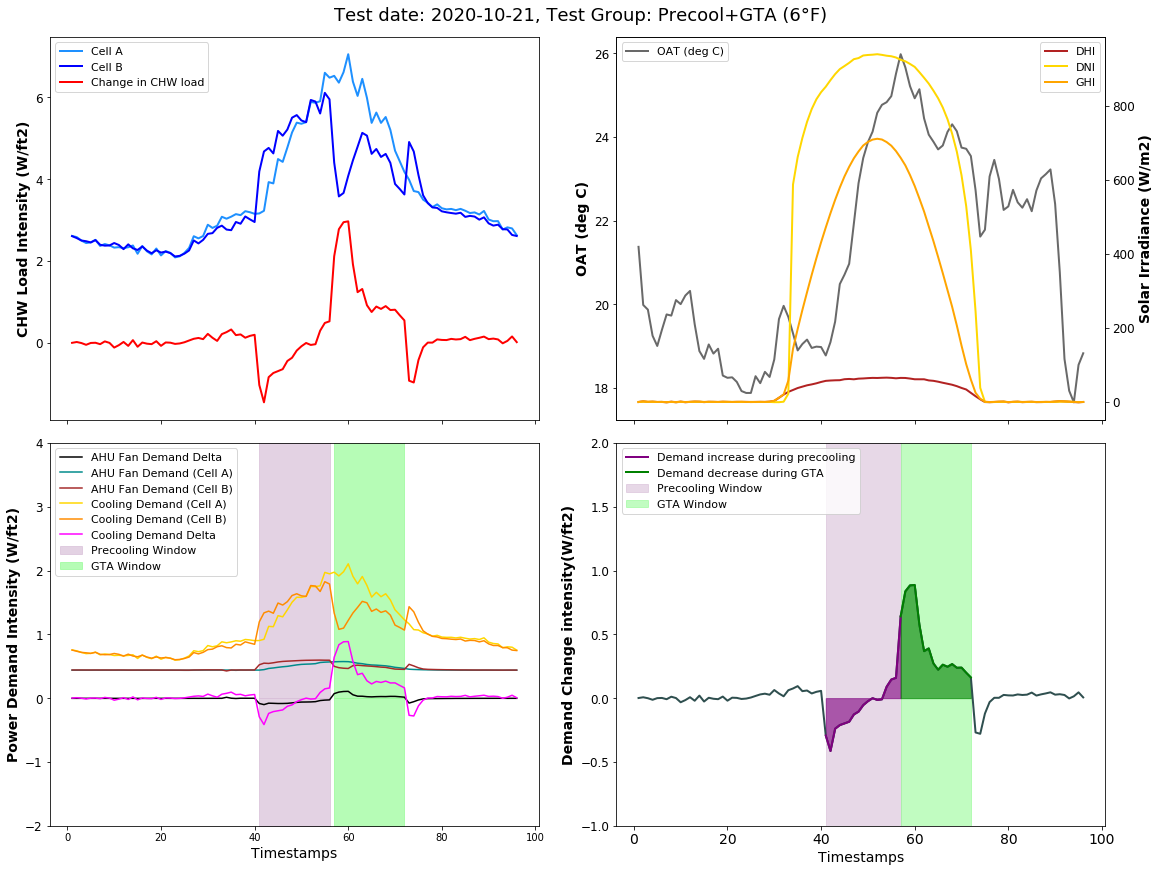

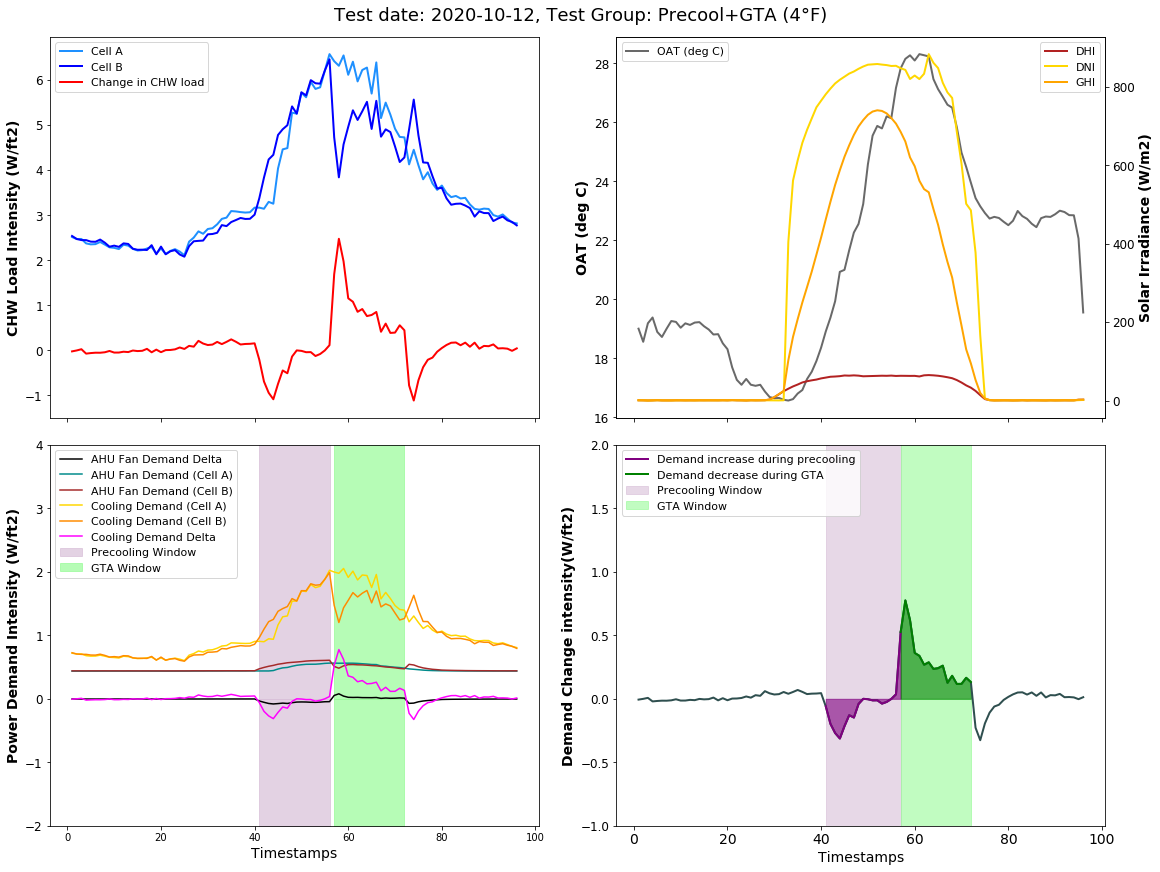

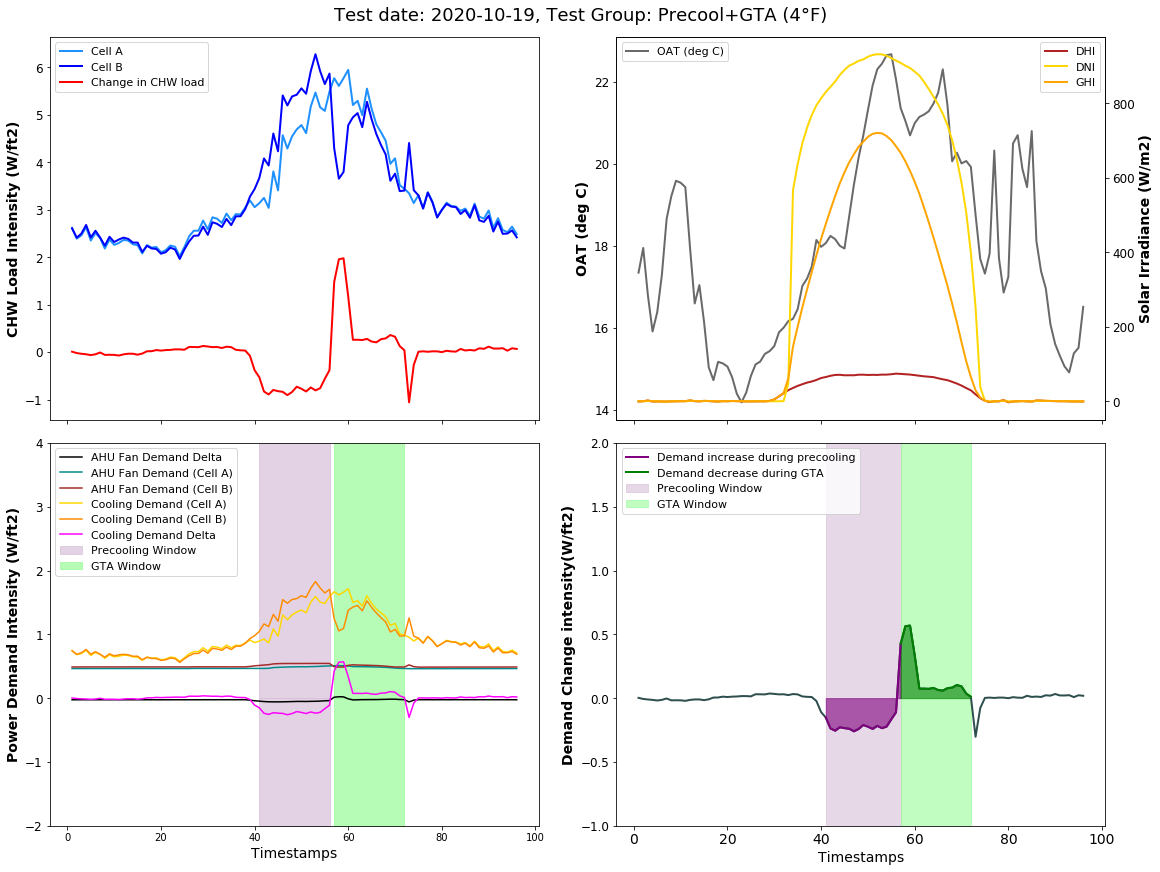

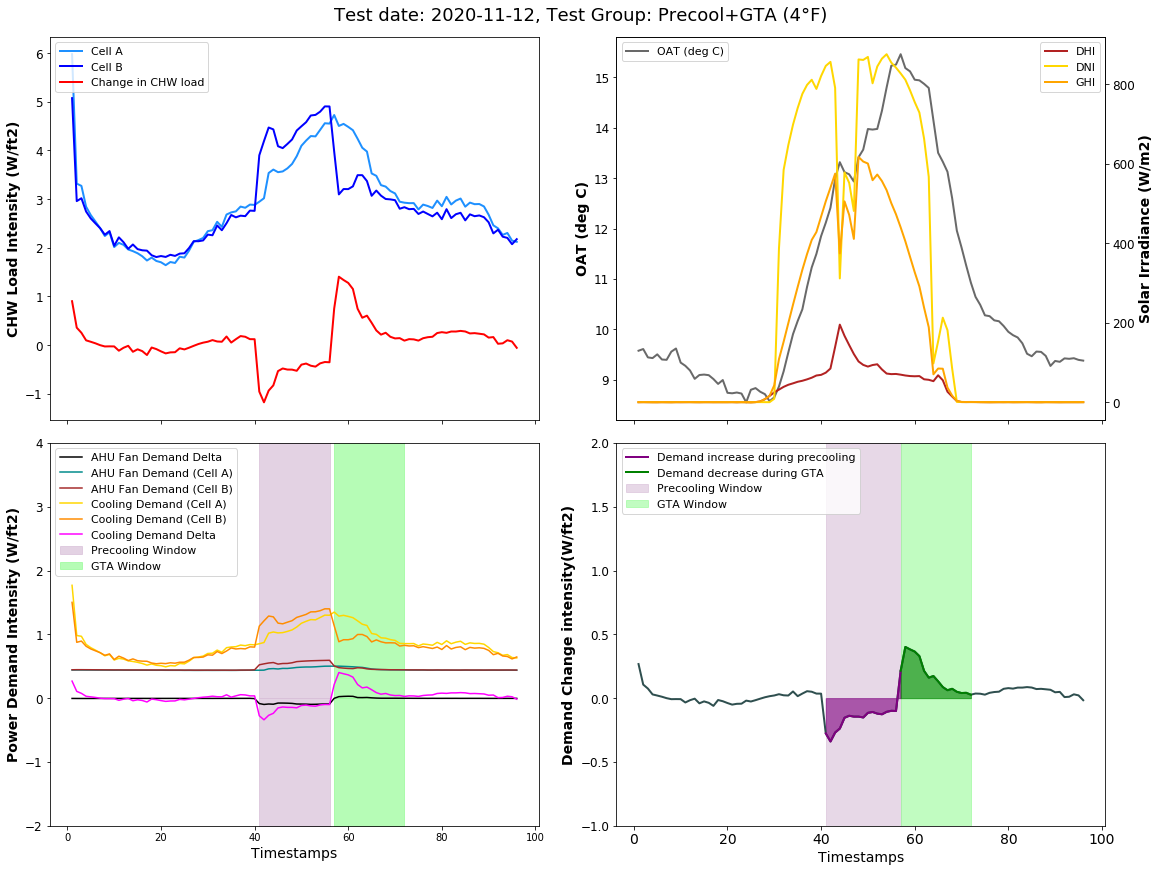

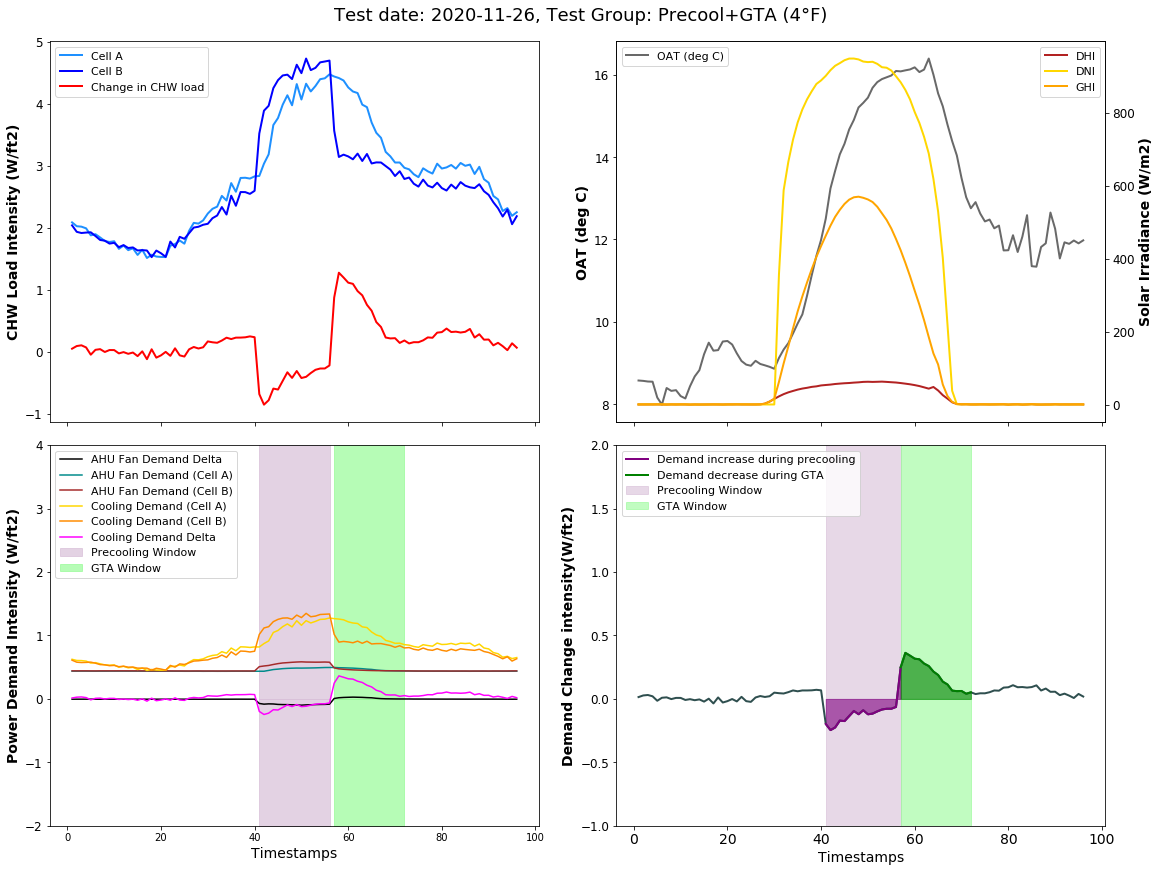

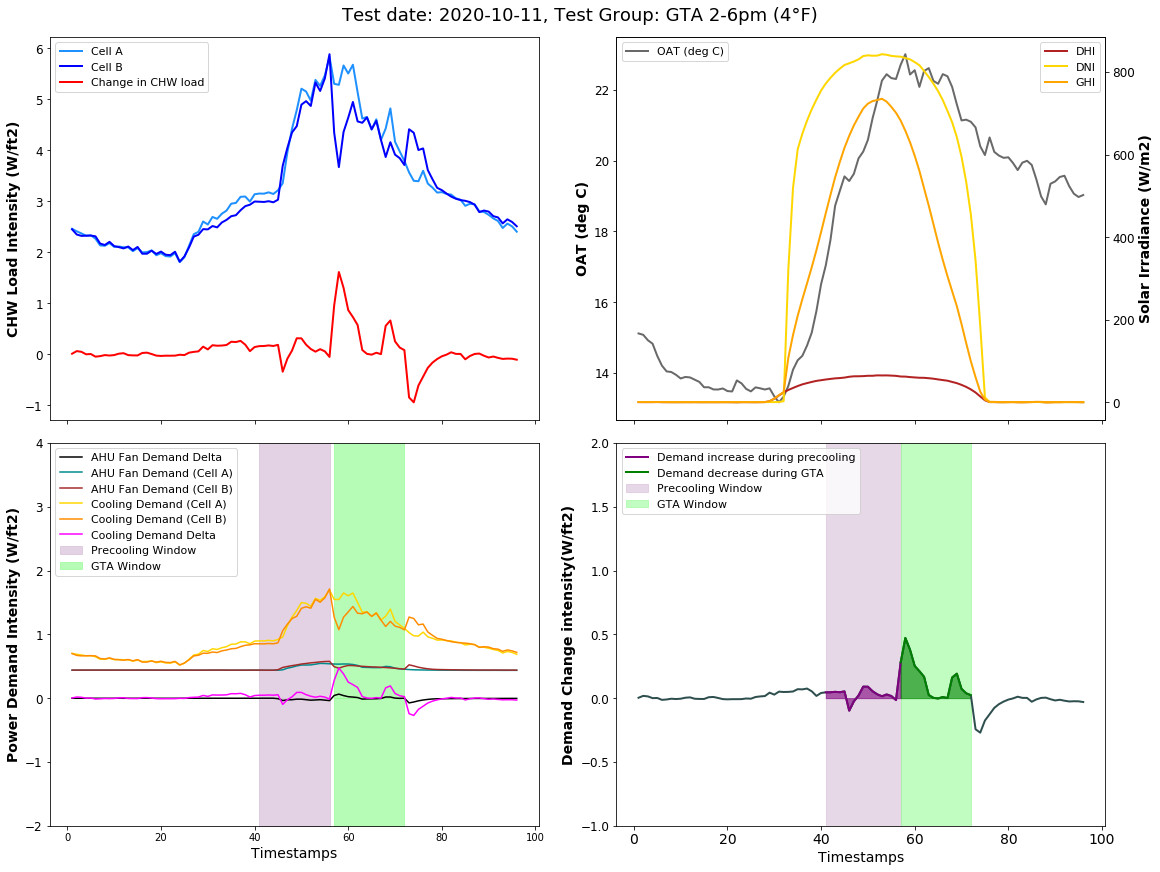

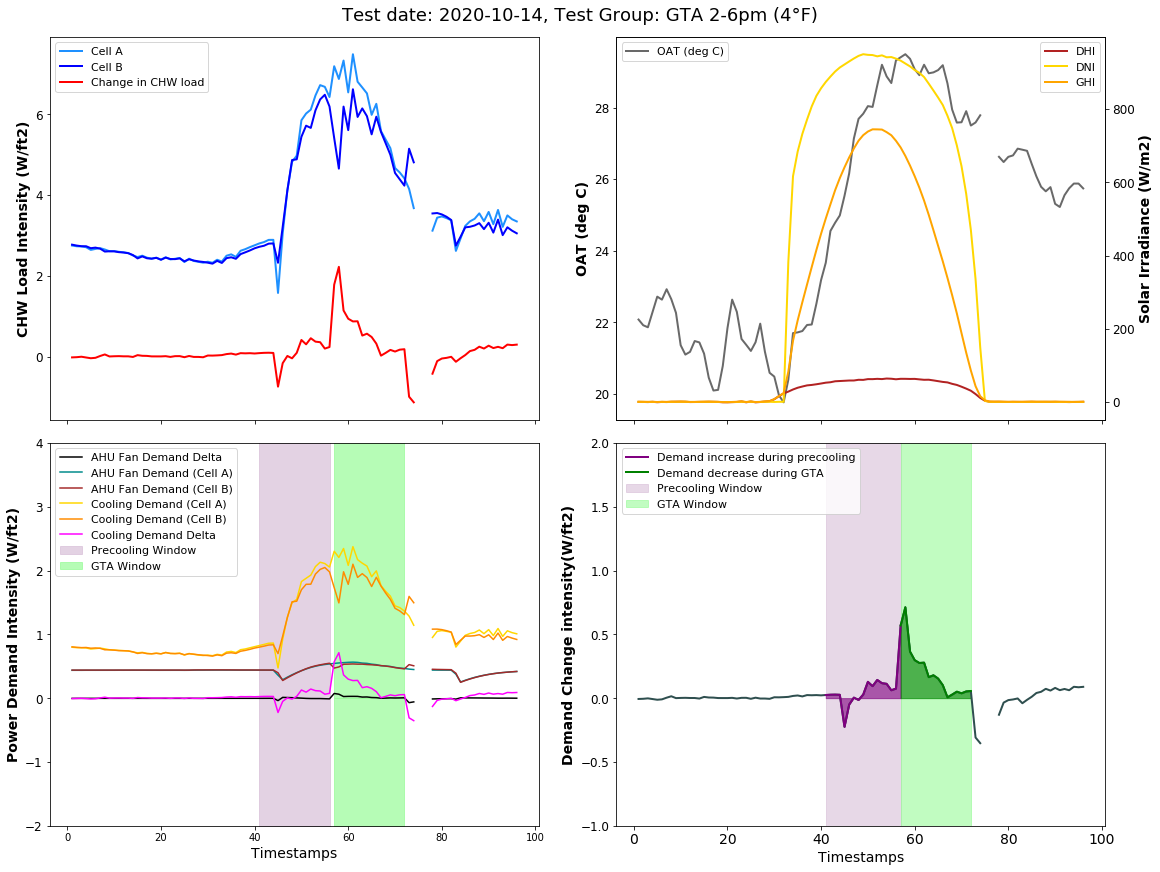

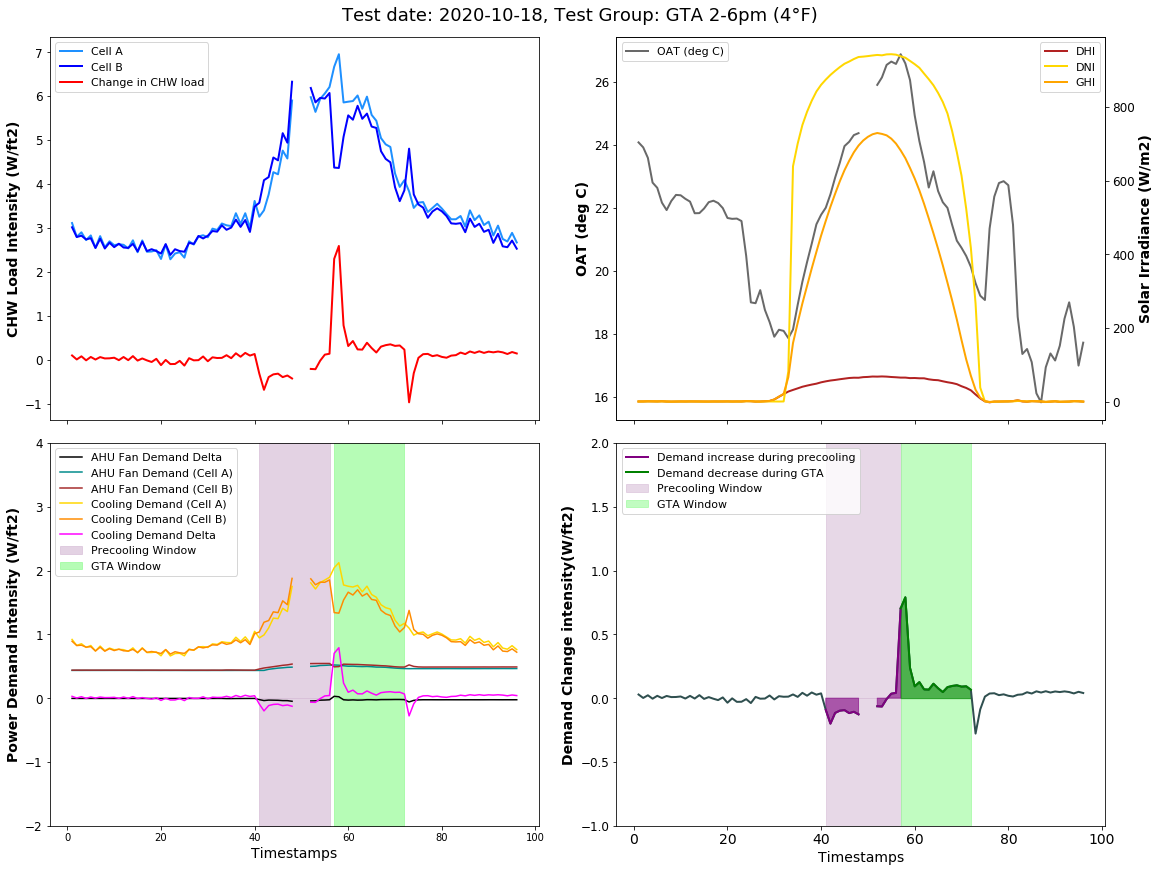

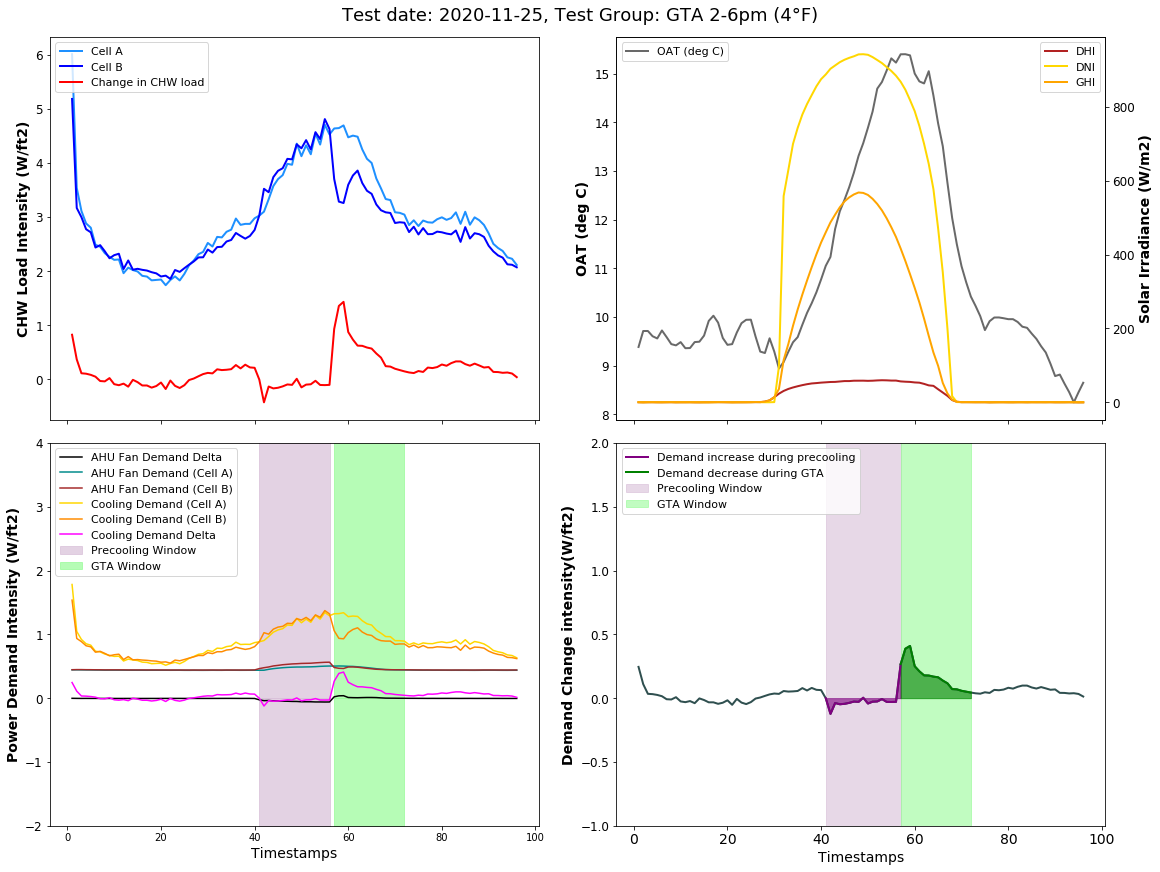

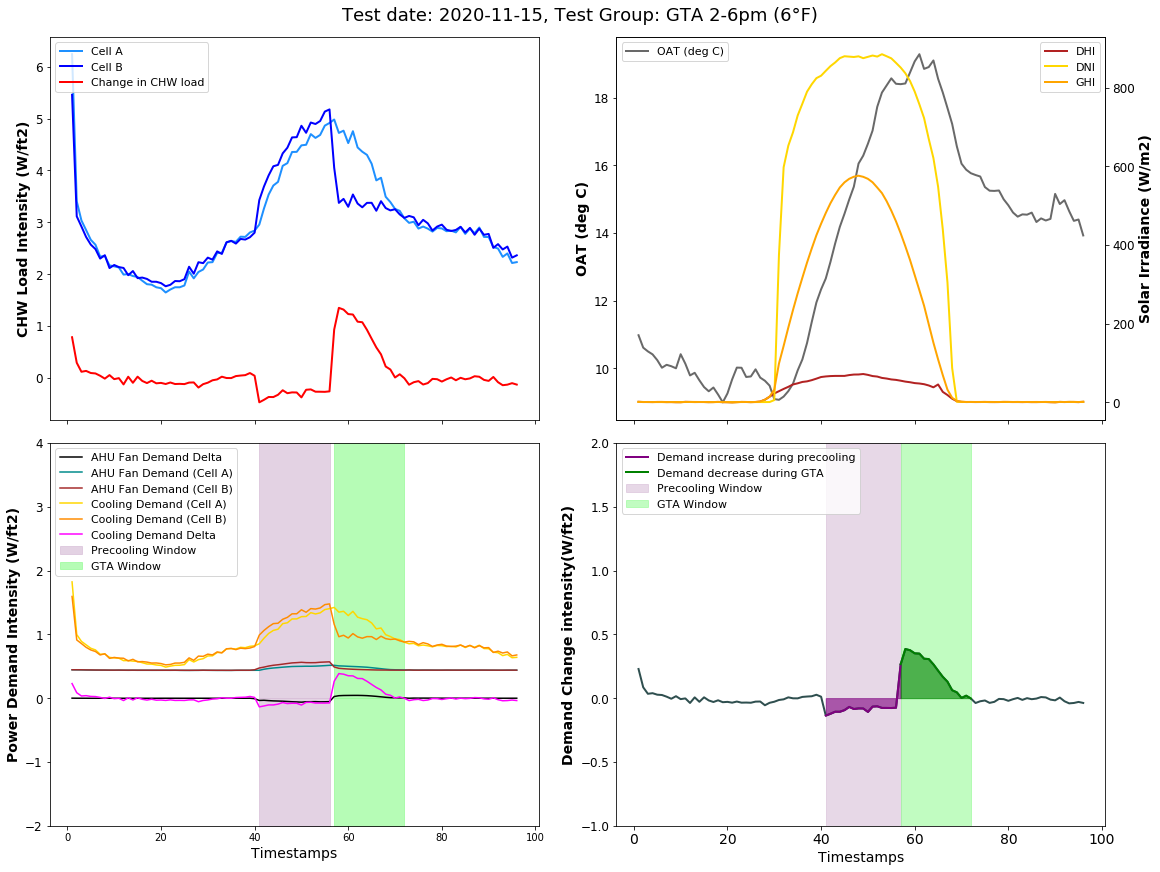

In [109]:
for i in range(len(select_dates)):
    mask_1 = [x.date() == select_dates[i] for x in df_1['Date']]
    df_plot = df_1[mask_1]
    mask_2 = [x == select_dates[i] for x in df_2['day_revised']]
    
    plt.close
    fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2,constrained_layout=True, sharex=True, figsize = (16,12))
    x = np.arange(1,97)
    # subplot 1
    p11, = ax.plot(x, df_plot['CHW_A_th_intensity'][0:96], color = 'dodgerblue', label = 'Cell A', linewidth=2)
    p12, = ax.plot(x, df_plot['CHW_B_th_intensity'][0:96], color = 'blue', label = 'Cell B', linewidth=2)
    p13, = ax.plot(x, df_plot['CHW_th_diff_intensity'][0:96], color = 'red', label = 'Change in CHW load', linewidth=2)
    #p14, = ax.plot(x, df_plot['1A-Th-Chilled Water_new_adjusted'][0:96], color = 'olive', label = 'Corrected CHW load', 
    #linewidth=2)

    ax.legend(fontsize = 11, loc= 'upper left')
    #ax.set_xlabel('Timestamp', fontsize = 14)
    ax.tick_params(axis = 'y', labelsize = 12)
    ax.tick_params(axis = 'x')
    ax.set_frame_on(True)
    #ax.set_ylim(0,120)
    ax.set_ylabel('CHW Load Intensity (W/ft2)', color = 'black', fontsize = 14, fontweight= 'bold')
    ax.get_yaxis().set_visible(True)
    plt.suptitle('Test date: ' + str(select_dates[i]) + ', Test Group: ' 
                         +str(df_2['Test Group'][mask_2].values[0]), fontsize = 18)
    #fig.suptitle('this is the figure title', fontsize=12)
    # subplot 2
    p21, = ax1.plot(x, df_plot['1B-OAT-1'][0:96], color = 'dimgrey', label = 'OAT (deg C)', linewidth=2)
    ax1.legend(fontsize = 11, loc= 'upper left')
    #ax.set_xlabel('Timestamp', fontsize = 14)
    ax1.tick_params(axis = 'y', labelsize = 12)
    ax1.tick_params(axis = 'x')
    ax1.set_frame_on(True)
    #ax.set_ylim(0,120)
    ax1.set_ylabel('OAT (deg C)', color = 'black', fontsize = 14, fontweight= 'bold')
    ax1.get_yaxis().set_visible(True)

    ax12 = ax1.twinx()
    p22, = ax12.plot(x, df_plot['DHI'][0:96], color = 'firebrick', label = 'DHI', linewidth=2)
    p23, = ax12.plot(x, df_plot['DNI'][0:96], color = 'gold', label = 'DNI', linewidth=2)
    p24, = ax12.plot(x, df_plot['GHI'][0:96], color = 'orange', label = 'GHI', linewidth=2)
    #ax12.set_ylim(0,3000)
    ax12.legend(fontsize = 11, loc= 'upper right')
    ax12.set_ylabel('Solar Irradiance (W/m2)', color = 'black', fontsize = 14, fontweight= 'bold')
    ax12.tick_params(labelsize = 12)
    #ax12.set_yticks(np.arange(0, 5000, 1000))

    # subplot 3
   
    ax2.fill_between(x[40:56], 0, df_plot['upper'][40:56], color = 'thistle', alpha = 0.7)
    ax2.fill_between(x[40:56], 0, df_plot['lower'][40:56], color = 'thistle', alpha = 0.7, label = 'Precooling Window')
    ax2.fill_between(x[56:72], 0, df_plot['upper'][56:72], color = 'palegreen',alpha = 0.7)
    ax2.fill_between(x[56:72], 0, df_plot['lower'][56:72], color = 'palegreen', alpha = 0.7, label = 'GTA Window')
    
    p31, = ax2.plot(x, df_plot['AHU_El_diff_intensity'][0:96], label = 'AHU Fan Demand Delta', color = 'black')
    p32, = ax2.plot(x, df_plot['1A-El-AHU_intensity'][0:96], label = 'AHU Fan Demand (Cell A)', color = 'darkcyan')
    p33, = ax2.plot(x, df_plot['1B-El-AHU_intensity'][0:96], label = 'AHU Fan Demand (Cell B)', color = 'brown')
    p34, = ax2.plot(x, df_plot['CHW_A_El_intensity'][0:96], label = 'Cooling Demand (Cell A)', color = 'gold')
    p35, = ax2.plot(x, df_plot['CHW_B_El_intensity'][0:96], label = 'Cooling Demand (Cell B)', color = 'darkorange')
    p36, = ax2.plot(x, df_plot['CHW_El_diff_intensity'][0:96], label = 'Cooling Demand Delta', color = 'magenta')
    
    ax2.legend(fontsize = 11, loc= 'upper left')
    
    ax2.set_xlabel('Timestamps', fontsize = 14)
    ax2.tick_params(axis = 'y', labelsize = 12)
    ax2.set_frame_on(True)
    ax2.set_ylim(-2, 4)
    ax2.set_ylabel('Power Demand Intensity (W/ft2)', color = 'black', fontsize = 14, fontweight= 'bold')
    ax2.get_yaxis().set_visible(True)
    
    # subplot 4
    p41, = ax3.plot(x, df_plot['Load_El_intensity'], color = 'darkslategrey', linewidth=2)
    p42, = ax3.plot(x[40:57], df_plot['Load_El_intensity'][40:57], color = 'purple', 
                    label = 'Demand increase during precooling', linewidth=2)
    p43, = ax3.plot(x[56:72], df_plot['Load_El_intensity'][56:72], color = 'green', 
                    label = 'Demand decrease during GTA', linewidth=2)
    
    ax3.fill_between(x[40:57], 0, df_plot['upper'][40:57], color = 'thistle', alpha = 0.6)
    ax3.fill_between(x[40:57], 0, df_plot['lower'][40:57], color = 'thistle', alpha = 0.6, label = 'Precooling Window')
    ax3.fill_between(x[56:72], 0, df_plot['upper'][56:72], color = 'palegreen',alpha = 0.6)
    ax3.fill_between(x[56:72], 0, df_plot['lower'][56:72], color = 'palegreen', alpha = 0.6, label = 'GTA Window')
    
    ax3.fill_between(x[40:57], 0, df_plot['Load_El_intensity'][40:57], color = 'purple',alpha = 0.6)
    ax3.fill_between(x[56:72], 0, df_plot['Load_El_intensity'][56:72], color = 'green',alpha = 0.6)
    
    ax3.legend(fontsize = 11, loc= 'upper left')
    ax3.set_xlabel('Timestamps', fontsize = 14)
    ax3.tick_params(axis = 'y', labelsize = 12)
    ax3.tick_params(axis = 'x', labelsize = 14)
    ax3.set_frame_on(True)
    ax3.set_ylim(-1, 2)
    ax3.set_ylabel('Demand Change intensity(W/ft2)', color = 'black', fontsize = 14, fontweight = 'bold')
    ax3.get_yaxis().set_visible(True)

    fig.savefig('DF metrics plots.png')

### Metrics calculations

In [110]:
demand_dec_int = []
demand_inc_int = []
net_energy_cons = []
max_demand_a = []
max_demand_b = []
test_groups = []
oat = []

for i in range(len(select_dates)):
    mask_1 = [x.date() == select_dates[i] for x in df_1['Date']]
    mask_2 = [x == select_dates[i] for x in df_2['day_revised']]
    #print(df_1['Date'][mask_1])
    daily_demand_inc_int =df_1['CHW_El_diff_intensity'][mask_1][precool_dur].mean() 
    demand_inc_int.append(daily_demand_inc_int)
    
    daily_demand_dec_int =df_1['CHW_El_diff_intensity'][mask_1][shed_dur].mean()
    demand_dec_int.append(daily_demand_dec_int)
    
    daily_net_energy = (df_1['CHW_El_diff_intensity'][mask_1].sum()/4)
    net_energy_cons.append(daily_net_energy)
    
    daily_max_demand_a = (df_1['1A-El-AHU_intensity'] + df_1['CHW_A_El_intensity'])[mask_1].max()
    max_demand_a.append(daily_max_demand_a)
    
    daily_max_demand_b = (df_1['1B-El-AHU_intensity'] + df_1['CHW_B_El_intensity'])[mask_1].max()
    max_demand_b.append(daily_max_demand_b)
    
    test_groups.append(df_2['Test Group'][mask_2].values[0])
    
    oat.append(df_1['OAT_F'][mask_1][shed_dur].mean())
print(test_groups)

['Precool+GTA (6°F)', 'Precool+GTA (4°F)', 'Precool+GTA (4°F)', 'Precool+GTA (4°F)', 'Precool+GTA (4°F)', 'GTA 2-6pm (4°F)', 'GTA 2-6pm (4°F)', 'GTA 2-6pm (4°F)', 'GTA 2-6pm (4°F)', 'GTA 2-6pm (6°F)']


In [111]:
proxy_val = [100,100,100,100,100,100,100,100,100,100]
fig2 = go.Figure()
fig2 = make_subplots(rows = 1, cols = 1, specs = [[{"secondary_y": True}]], shared_xaxes = False,
                    vertical_spacing = 0.05, horizontal_spacing = 0.15, subplot_titles=['Metrics'])         

x = np.arange(len(dates_str))
width = .2
fig2.add_trace(go.Scatter(x = dates_str, y = proxy_val, showlegend = False), secondary_y = True)
fig2.add_trace(go.Bar(x = dates_str, y= np.array(demand_dec_int), name = 'Demand Decrease intensity (kW/sq.ft.)', 
                      marker_color='green'))
fig2.add_trace(go.Bar(x = dates_str, y = np.array(demand_inc_int), name = 'Demand Increase intensity (kW/sq.ft.)', 
                      marker_color='purple'))
fig2.add_trace(go.Bar(x = dates_str, y = net_energy_cons, name = 'Net KWh Change %', marker_color='grey'))
fig2.add_trace(go.Scatter(x = dates_str, y = max_demand_a, name = 'Daily peak demand (kW/sq.ft.)', 
                      marker_color = 'goldenrod'))


fig2.update_layout(height = 500, width = 980,title_text = 'Metrics Plot', title_x = 0.45,
                 legend = dict(orientation ="h", yanchor = "bottom", y = -.5, xanchor = "left", x= .1))
fig2.update_yaxes(title_text= "Demand Change intensity", row = 1, col = 1, range = [-8, 12], secondary_y = False)
fig2.update_yaxes(title_text = "Net KWh Change %", row = 1, col = 1,range = [-2.5,2.5],secondary_y = True)
fig2.update_xaxes(title_text = 'Dates', type='category')
fig2.show()

### Scatter plot

In [112]:
df_4 = pd.DataFrame([demand_dec_int, demand_inc_int, net_energy_cons, max_demand_a, select_dates, test_groups, oat])
df_4 = df_4.transpose()
df_4.columns=['demand_dec','demand_inc','net_energy', 'max_demand', 'dates', 'Test group', 'OAT']
#df_4['dates'] = df_2['day_revised']
#df_4['tests'] = df_2['Test Group'][mask_1]
#df_4['OAT'] = df_2['Avg OAT (°F)']

In [113]:
print(df_4)

  demand_dec demand_inc net_energy max_demand       dates         Test group  \
0   0.418193 -0.0923099    1.40608    2.67676  2020-10-21  Precool+GTA (6°F)   
1   0.296829 -0.0891435   0.838055    2.61237  2020-10-12  Precool+GTA (4°F)   
2   0.170322  -0.216841  -0.184007    2.21857  2020-10-19  Precool+GTA (4°F)   
3   0.172148  -0.164326   0.435597    2.20879  2020-11-12  Precool+GTA (4°F)   
4    0.19087  -0.130617    0.78427    1.76996  2020-11-26  Precool+GTA (4°F)   
5   0.142855  0.0281821   0.543794    2.23448  2020-10-11    GTA 2-6pm (4°F)   
6   0.208081  0.0363044   0.986864    2.93866  2020-10-14    GTA 2-6pm (4°F)   
7   0.178463  -0.077685   0.643662    2.63877  2020-10-18    GTA 2-6pm (4°F)   
8   0.172414 -0.0331175    1.08753    2.22423  2020-11-25    GTA 2-6pm (4°F)   
9   0.202731 -0.0888042   0.354403    2.26631  2020-11-15    GTA 2-6pm (6°F)   

       OAT  
0  75.9211  
1  80.4762  
2   69.684  
3  56.5015  
4  59.2689  
5  71.8558  
6  83.6109  
7  73.4381  
8 

In [114]:
def metric_plot(metric, test_list, inp_df, text, markers, colors, yaxis_range, xaxis_range):
    plt.close
    fig, ax = plt.subplots(constrained_layout=True, figsize = (14,8))

    x = inp_df['OAT']
    for i, label in enumerate(test_list):
        #print(test_list, label)
        mask_1 = inp_df['Test group'] == label
        
        plt.scatter(x = x[mask_1], y = metric[mask_1], s = 85, color = colors[i], label = label, 
                    marker = markers[i])
        
        plt.title('Plot for ' + str(text), fontsize = 16)
        plt.legend(title = 'Legend', bbox_to_anchor = (1, 1), loc = 'upper left', fontsize = 9)
        plt.ylabel(text, color = 'black', fontsize = 14)
        plt.xlabel('OAT (deg F)', color = 'black', fontsize = 14)
        plt.ylim(yaxis_range)
        plt.xlim(xaxis_range)
    fig.savefig('DF metrics plots.png')

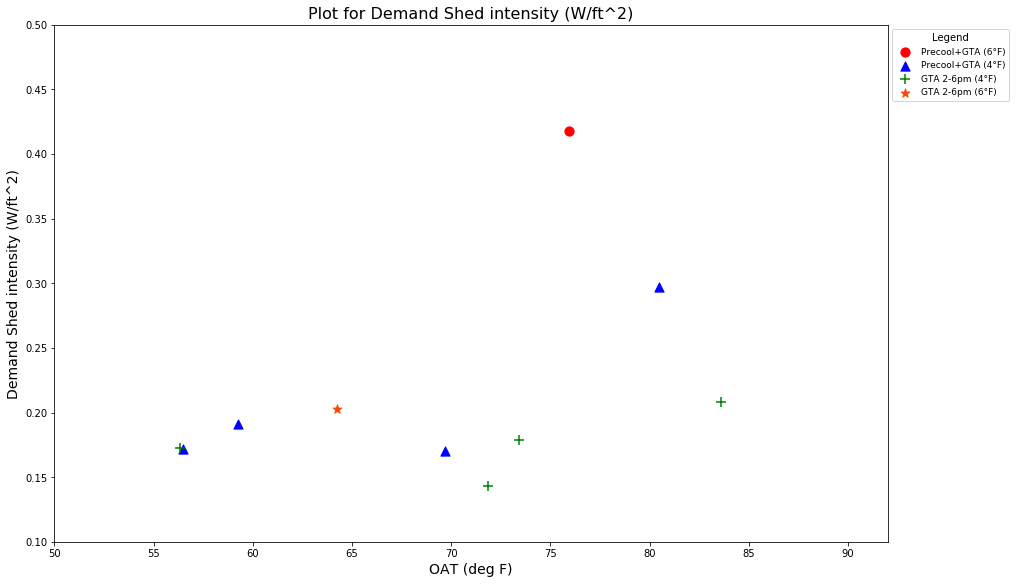

In [120]:
markers = [135, 7, 200, 2, 5, 4, 7, 0, 135, 200, 2, 5, 4]
markers = ['o','^', '+', '*', 'v','X','P', 'o', '^', '+','*','v', 'X']
colors = ['red', 'blue', 'green', 'orangered', 'magenta', 'goldenrod', 'magenta', 'goldenrod', 'maroon','indigo',
          'green', 'orangered', 'dodgerblue']

metric_plot(metric = df_4['demand_dec'], test_list = df_4['Test group'].unique(), inp_df = df_4, text = 'Demand Shed intensity (W/ft^2)',
            markers = markers, colors = colors, yaxis_range =[0.1,0.5], xaxis_range = [50,92])


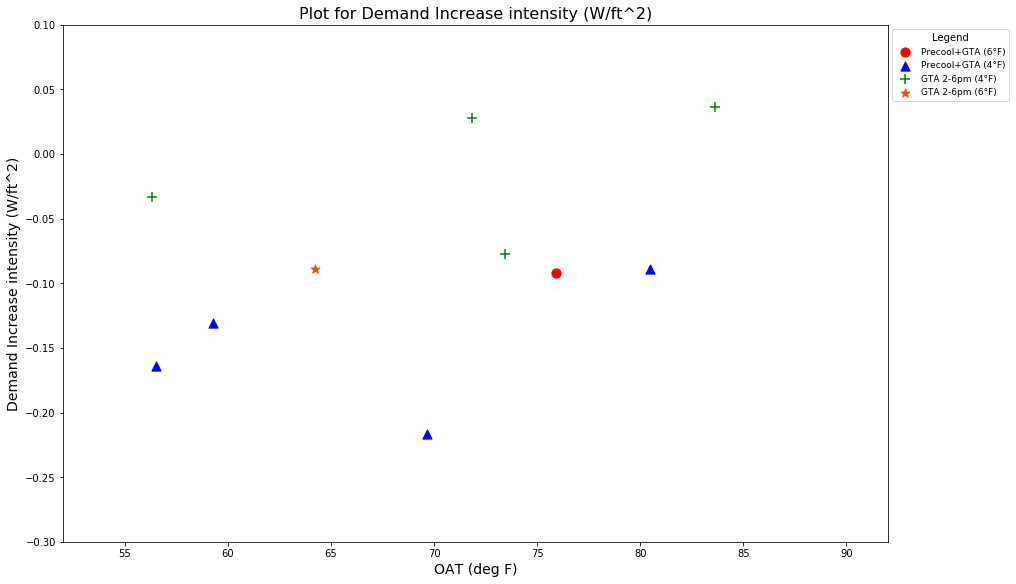

In [119]:
metric_plot(metric = df_4['demand_inc'], test_list = df_4['Test group'].unique(), inp_df = df_4, 
            text = 'Demand Increase intensity (W/ft^2)',
           markers = markers, colors = colors, yaxis_range =[-0.3,0.1],xaxis_range =[52,92])

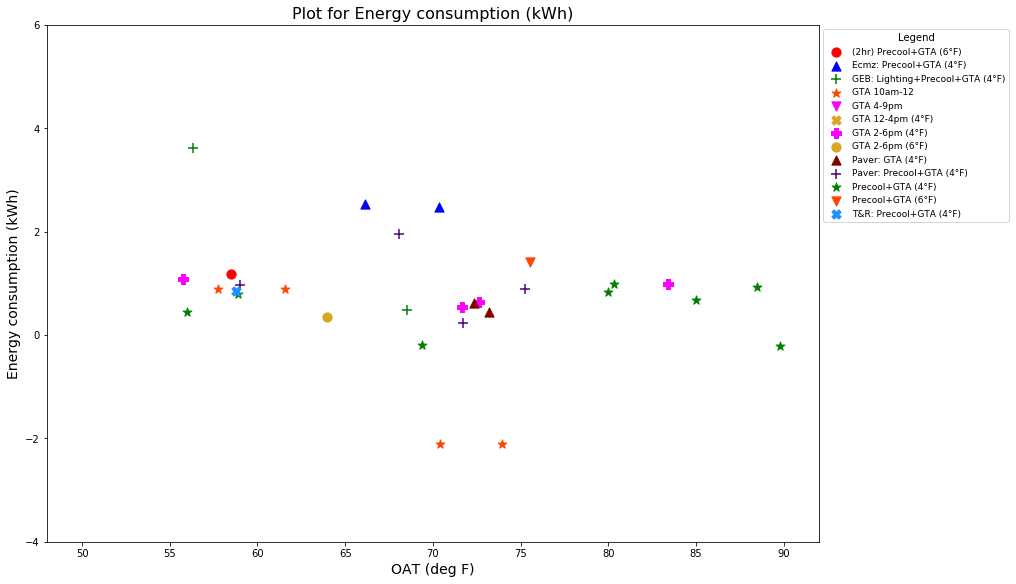

In [91]:
metric_plot(metric = df_4['net_energy'], test_list = df_4['Test group'].unique(), inp_df = df_4, 
            text = 'Energy consumption (kWh)', 
           markers = markers, colors = colors, yaxis_range =[-4,6], xaxis_range = [48,92])

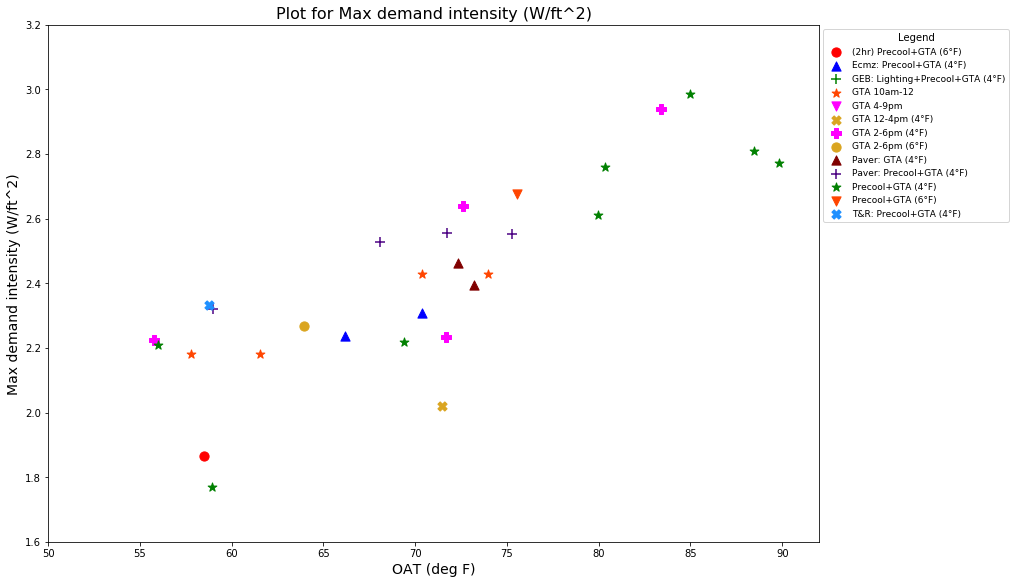

In [92]:
metric_plot(metric = df_4['max_demand'], test_list = df_4['Test group'].unique(), inp_df = df_4, 
            text = 'Max demand intensity (W/ft^2)', 
           markers = markers, colors = colors, yaxis_range =[1.6,3.2], xaxis_range = [50,92])

In [254]:
print(demand_dec_int)
#print(demand_inc_int)
#print(net_energy_cons)
#print(max_demand_a)
#print(max_demand_b)

[3.020855790331821, 2.5775939131627315, 4.5514264058464295, 3.3214687765505495, 4.250992033478263, 2.422702875769858]
